In [ ]:
import pandas as pd
import joblib
import os

In [ ]:
data = pd.read_parquet('Data/test_all_slopes.parquet')
data.shape

In [ ]:
def predict(data):
    
    models = [
        'fold_0_iter',
        'fold_1_iter',
        'fold_2_iter',
        'fold_3_iter',
        'fold_4_iter',
    ]

    model_list = []
    for path in ['models_DART_slope/']:
        for fname in os.listdir(path):
            for model_name in models:
                if model_name in fname:
                    model_list.append(path + fname)

    pred_list = []
    for model_path in model_list:
        print(model_path)
        print('{:.02f} MB'.format(os.path.getsize(model_path)/1000000))
        model = joblib.load(model_path)
        pred_list.append(model.predict(data))
    
    return pred_list

In [ ]:
pred_list = predict(data)

In [ ]:
column_name = [
    'fold_1',
    'fold_0',
    'fold_2',
    'fold_4',
    'fold_3',
]

pred_df = pd.DataFrame(pred_list).T
pred_df.columns = column_name
pred_df.index = data.index

In [ ]:
pred_df

In [ ]:
pred_df.to_csv('Output/p_LgbmDART_AggPcaDiffRoundSlope_HT1234_folds.csv')
pred_df.mean(axis=1).to_csv('Output/p_LgbmDART_AggPcaDiffRoundSlope_HT1234.csv', header=['prediction'])

### Evaluate the folds

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
pred_df = pd.read_csv('Output/p_LgbmDART_AggPcaDiffRoundSlope_HT1234_folds.csv', index_col='customer_ID')
columns = pred_df.columns
pred_df.shape

(924621, 5)

In [3]:
pred_df['mean'] = pred_df[columns].mean(axis=1)
pred_df['min'] = pred_df[columns].min(axis=1)
pred_df['max'] = pred_df[columns].max(axis=1)
pred_df['median'] = pred_df[columns].median(axis=1)
pred_df['skew'] = pred_df[columns].skew(axis=1)
pred_df['kurtosis'] = pred_df[columns].kurtosis(axis=1)
pred_df['diff'] = pred_df['max'] - pred_df['min']
pred_df.shape

(924621, 12)

In [4]:
pred_df.sort_values('mean', ascending=False, inplace=True)
n_components = 10
pca = PCA(n_components=n_components, random_state=42)
pred_PCA = pca.fit_transform(pred_df)
pred_PCA_df = pd.DataFrame(pred_PCA, index=pred_df.index, columns=['PCA' + str(i) for i in range(n_components)])
pred_PCA_df['rank'] = range(0, pred_PCA_df.shape[0], 1)
print(pca.explained_variance_ratio_)

[6.71713037e-01 1.97516145e-01 1.30171254e-01 3.27461989e-04
 7.52038258e-05 6.89650709e-05 5.93557777e-05 5.90543448e-05
 8.26096705e-06 1.26257959e-06]


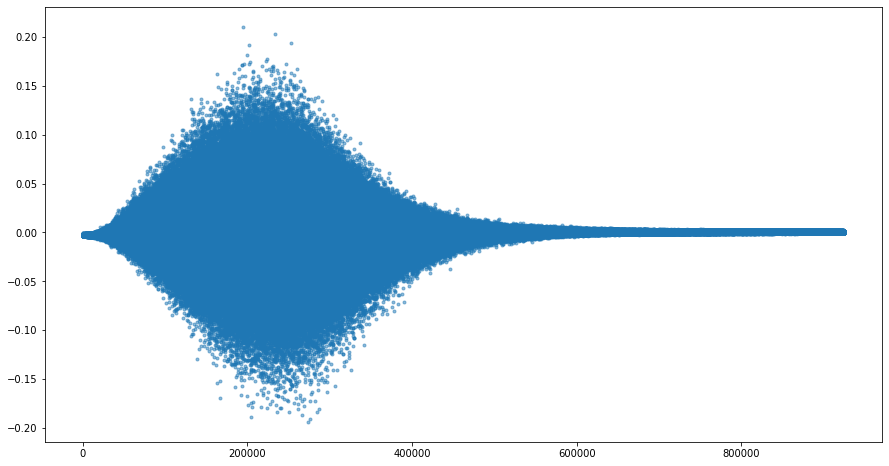

In [14]:
plt.figure(figsize=(15,8))
plt.plot(pred_PCA_df['rank'], pred_PCA_df['PCA4'], '.', alpha=0.5)
plt.show()

In [46]:
tsne = TSNE(random_state=42)
pca_columns = ['PCA' + str(i) for i in range(n_components)]
pred_TSNE = tsne.fit_transform(pred_PCA_df[pca_columns].iloc[:700000])

In [49]:
pred_TSNE_df = pd.DataFrame(pred_TSNE, columns=['TSNE1', 'TSNE2'], index=pred_PCA_df.iloc[:700000].index)
pred_TSNE_df = pd.concat([pred_TSNE_df, pred_PCA_df['rank']], axis=1).dropna(axis=0)

In [50]:
pred_TSNE_df

,TSNE1,TSNE2,rank
customer_ID,,,
dcab0bc40dfb3d46378d1509964bd81d91a74b44757b46255f1bc0581b09e898,26.908976,7.021392,0
a41fa6ad66fc6d0c6bb722b1971db6d8001fcf268cf98c7028192b6057a727ce,26.652115,7.323843,1
965fd46b3d332c83491a2e500facd53994880a75734e149426afbf3c2397c4fb,22.635277,-0.847037,2
7f84f6ff88a9367e2204d06484b61da48e19b1ccbece8da53dc3ed7d15dd83ae,27.194712,6.260408,3
7bd3b26bd48b1ecac2ac192bd5b0789e336d3f1fd6ac2f6a7891b9f55a749178,22.635269,-0.847037,4
...,...,...,...
75740d2aac3878ec5d467c0e273b523a174f9862c93ab0d817d2e630b55eb670,15.424668,-6.077661,699995
85dde077b52826017f89a1fd377ea82f081ad15eb219f5dfd26d9c032b24267b,3.307847,-16.206455,699996
10d66baa03597840043a0747cb721985b052bbf497586d0f8abd6c49f2965cef,-8.698542,-4.488196,699997


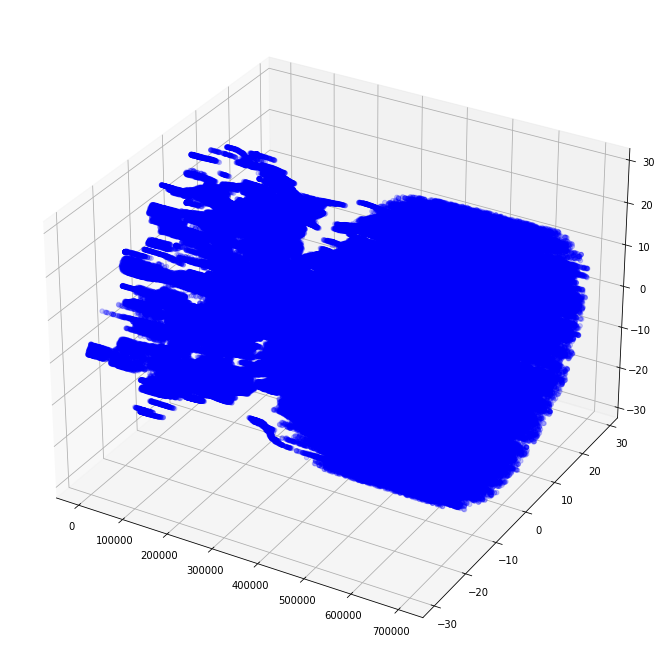

In [61]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(pred_TSNE_df['rank'], pred_TSNE_df['TSNE1'], pred_TSNE_df['TSNE2'], c='blue', alpha=0.2)
plt.show()